In [1]:
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

import os
import numpy as np
import cv2
import glob
import tarfile
my_tar = tarfile.open('BSR_bsds500.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()
import glob,os
img_dir = "BSR/BSDS500/data/images/train" 
data_path = os.path.join(img_dir,'*jpg')
files = glob.glob(data_path)


img_dir_test = "BSR/BSDS500/data/images/test" 
data_path_test = os.path.join(img_dir_test,'*jpg')
files_test = glob.glob(data_path_test)

img_dir_val = "BSR/BSDS500/data/images/val" 
data_path_val = os.path.join(img_dir_val,'*jpg')
files_val = glob.glob(data_path_val)
len(files)

--2021-02-28 10:12:32--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2021-02-28 10:12:33--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2021-02-28 10:12:33--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

200

In [2]:
import time
from glob import glob
import numpy as np
import tensorflow as tf
import random
import os
import cv2

patch_size, stride = 40, 10
aug_times = 1
scales = [1, 0.9, 0.8, 0.7]
batch_size = 128

def data_aug(img, mode=0):

    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

def gen_patches(file_name, scales=[1,0.9,0.8,0.7], patch_size=40, stride=10, aug_times=1):
    # read image
    img = cv2.imread(file_name,0)
    img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_CUBIC)
    h, w= img.shape
    patches = []
    for s in scales:
        h_scaled, w_scaled = int(h*s), int(w*s)
        img_scaled = cv2.resize(img, (h_scaled, w_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        n1 = int((h_scaled - patch_size) / stride)
        n2 = int((w_scaled - patch_size) / stride)
        for i2 in range(n2-1):
            for i1 in range(n1-1):
                x = img_scaled[i1*stride:i1*stride+patch_size, 
                        i2*stride:i2*stride+patch_size]
                patches.append(x)
    return patches

def datagenerator(file_list):

    data = []
    # generate patches
    for i in range(len(file_list)):
        patch = gen_patches(file_list[i])
        data.append(patch)
       
    data = np.array(data)
    print(data.shape)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],1))
    discard_n = len(data)-len(data)//batch_size*batch_size;
    data = np.delete(data,range(discard_n),axis = 0)
    print('^_^-training data finished-^_^')
    return data

data = datagenerator(files)

(200, 596, 40, 40)
^_^-training data finished-^_^


In [3]:
import argparse
import re
import os, glob, datetime
import numpy as np
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,PReLU,Add,Average,ConvLSTM2D,Lambda,MaxPooling2D,Dropout,UpSampling2D,Concatenate,Multiply
from tensorflow.keras.metrics import MeanTensor
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam,Adagrad

import tensorflow.keras.backend as K

n_init_features = 64
def find_medians(x, k=3):
    patches = tf.image.extract_patches(
            x, 
            sizes=[1, k, k, 1],
            strides = [1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME')
    m_idx = int(k*k/2 + 1)
    top, _ = tf.nn.top_k(patches, m_idx, sorted=True)
    median = tf.slice(top, [0, 0, 0, m_idx-1], [-1, -1, -1, 1])
    return median

def SqueezeExcite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]
    y = tf.keras.layers.GlobalAveragePooling2D()(x)
    y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
    y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
    y = tf.keras.layers.Multiply()([x, y])
    return y

def median_pool2d(x, k=3):
    channels = tf.split(x, num_or_size_splits=x.shape[3], axis=3)
    for channel in channels:
        channel = find_medians(channel, k)
    median = tf.concat(channels, -1)
    return median

def median_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    return tuple(shape) 

def _residual_block(inputs, feature_dim=64):
  x = Conv2D(feature_dim, kernel_size = (3, 3),padding = "same",dilation_rate=(4,4),kernel_initializer="orthogonal")(inputs)
  x = BatchNormalization()(x)
  m = Add()([x, inputs])
  return m



In [4]:
import argparse
import re
import os, glob, datetime
import numpy as np
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,PReLU,Add,Average,Lambda,MaxPooling2D,Dropout,UpSampling2D,Concatenate,Multiply
from tensorflow.keras.metrics import MeanTensor
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam,Adagrad

import tensorflow.keras.backend as K

n_init_features = 64
def find_medians(x, k=3):
    patches = tf.image.extract_patches(
            x, 
            sizes=[1, k, k, 1],
            strides = [1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='SAME')
    m_idx = int(k*k/2 + 1)
    top, _ = tf.nn.top_k(patches, m_idx, sorted=True)
    median = tf.slice(top, [0, 0, 0, m_idx-1], [-1, -1, -1, 1])
    return median

def SqueezeExcite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]
    y = tf.keras.layers.GlobalAveragePooling2D()(x)
    y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
    y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
    y = tf.keras.layers.Multiply()([x, y])
    return y

def median_pool2d(x, k=3):
    channels = tf.split(x, num_or_size_splits=x.shape[3], axis=3)
    for channel in channels:
        channel = find_medians(channel, k)
    median = tf.concat(channels, -1)
    return median

def median_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    return tuple(shape) 

def _residual_block(inputs, feature_dim=64):
  x = Conv2D(feature_dim, kernel_size = (3, 3),padding = "same",dilation_rate=(4,4),kernel_initializer="orthogonal")(inputs)
  x = BatchNormalization()(x)
  m = Add()([x, inputs])
  return m

def IRCNN(filters=64,image_channels=1, use_bnorm=True):
    input_img = Input(shape=(None,None,image_channels))
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(input_img) 
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    input_ = tf.expand_dims(input_img,axis = 1)
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',kernel_initializer='Orthogonal')(x) 
    x = Activation('relu')(x)
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (2,2),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x)
    
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (3,3),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 
    
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (4,4),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x)
    
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (5,5),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 
    
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (6,6),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 

    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (5,5),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 
    x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (4,4),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (3,3),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',dilation_rate = (2,2),kernel_initializer='Orthogonal')(x)
    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
    x = Activation('relu')(x) 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',kernel_initializer='Orthogonal')(x)
    x_4 = Add()([x,input_img])
    model = Model(inputs=input_img, outputs=x_4)   
    return model

def CNN(depth,filters=64,image_channels=1, use_bnorm=True):
  layer_count = 0
  input_img = Input(shape=(None,None,image_channels))
  #input_ = tf.expand_dims(input_img,axis = 1)
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),padding='same',kernel_initializer='Orthogonal')(input_img) 
  x = Activation('relu')(x)

  for i in range(depth-2):
 
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same',use_bias = False,kernel_initializer='Orthogonal')(x)

    if use_bnorm:
      x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)

    x = Activation('relu')(x) 
    if i < (depth-2)//2:
        x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x)        

  x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1),padding='same',use_bias = False ,kernel_initializer='Orthogonal')(x)
  x_4 = Add()([x,input_img])
  model = Model(inputs=input_img, outputs=x_4)
    
  return model
def ADNet(filters = 64,image_channels = 1,use_bnorm = True):
  input_img = Input(shape=(None,None,image_channels))
  #input_ = tf.expand_dims(input_img,axis = 1)
  x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(input_img) 
  x = Lambda(median_pool2d, arguments={'k': 5},output_shape=median_pool2d_output_shape)(x)  
 
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',dilation_rate = (8,8),use_bias = False)(x)
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 


  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)   
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',dilation_rate = (8,8),use_bias = False)(x)
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)   
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x) 
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 


  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',dilation_rate = (8,8),use_bias = False)(x)
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)   
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x) 
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x)   

  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',dilation_rate = (8,8),use_bias = False)(x)
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Lambda(median_pool2d, arguments={'k': 5}, output_shape=median_pool2d_output_shape)(x) 
  #FEB
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x)   
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x) 
  x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x)
  x = Activation('relu')(x) 
  x_1 = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x)
  x_2 = Concatenate()([input_img,x_1])
  x_2 = Activation('tanh')(x_2)
  #AB
  x_2 = Conv2D(filters=image_channels, kernel_size=(1,1), strides=(1,1),kernel_initializer='Orthogonal', padding='same')(x_2)
  x_3 = Multiply()([x_1,x_2])
  #RB
  x_4 = Add()([x_3,input_img])
  
  model = Model(inputs = input_img,outputs = x_4)

  return model


def lr_schedule(epoch):
    initial_lr = 1e-3
    if epoch<=30:
        lr = initial_lr
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
   
    return lr

sigma = 10
def train_datagen(file_list,epoch_iter=2000,epoch_num=2,batch_size=128):
    while(True):
        n_count = 0
        if n_count == 0:
            #print(n_count)
            xs = datagenerator(file_list)
            xs = xs.astype('float32')/255.0
            indices = list(range(xs.shape[0]))
            n_count = 1
        for _ in range(epoch_num):
            np.random.shuffle(indices)    # shuffle
            for i in range(0, len(indices), batch_size):
                batch_x = xs[indices[i:i+batch_size]]
               
                noise =  np.random.normal(0, sigma/255.0, batch_x.shape)    # noise
                #noise =  K.random_normal(ge_batch_y.shape, mean=0, stddev=args.sigma/255.0)
                batch_y = batch_x + noise 

                yield batch_y, batch_x

             

def sum_squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))/2

#ir_model = IRCNN()
#ir_model.summary()
cnn_model = CNN(depth = 17)
cnn_model.summary()
#adnet_model = ADNet()
#adnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 6 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36864       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf
cnn_model = tf.keras.models.load_model("../input/cnn-model10/cnn_model10.h5",compile = False)
ir_model = tf.keras.models.load_model("../input/irr-model-10/irr_model10.h5",compile = False)
adnet_model = tf.keras.models.load_model("../input/adnet-model10/adnet_model10.h5",compile = False)

In [ ]:
import tensorflow as tf

def sum_squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))/2
def percent_mean_absolute_error(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true))

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
#cnn_model.compile(optimizer=Adam(0.001), loss = sum_squared_error)

#history_ensemble = cnn_model.fit(train_datagen(files),steps_per_epoch=1000, epochs=50, verbose=1)
cnn_model.compile(optimizer=Adam(0.001), loss = sum_squared_error)

history_ensemble = cnn_model.fit(train_datagen(files),steps_per_epoch=1000, epochs=50, verbose=1)

In [ ]:
cnn_model.save("cnn_model10.h5")
cnn_model.save_weights("cnn_model10w.h5")

In [ ]:
from PIL import Image
x = np.array(imread(f), dtype=np.float32) / 255.0
im = Image.fromarray(np.uint8(numpy_image)).convert('RGB')

In [ ]:
import argparse
import os, time, datetime
#import PIL.Image as Image
import numpy as np
from keras.models import load_model, model_from_json
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from skimage.io import imread, imsave
psnrs = []
ssim = []
sigma = 10
from PIL import Image
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))
    
for f in files_test:
  x = np.array(imread(f), dtype=np.float32) / 255.0
  np.random.seed(seed=0)
  y = x + np.random.normal(0, sigma/255.0, x.shape)
  y = y.astype(np.float32)
  y_  = to_tensor(y)
  start_time = time.time()
 
  x_ = cnn_model.predict(y_)

  elapsed_time = time.time() - start_time
  x_= from_tensor(x_)
  psnr_x_ = peak_signal_noise_ratio(x, x_)

  psnrs.append(psnr_x_)

In [ ]:

psnr_avg = np.mean(psnrs)

psnr_avg

In [ ]:
31.67 adnet without convlstm
31.684


In [ ]:
from PIL import Image
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))
    
import matplotlib.pyplot as plt 
import argparse
import os, time, datetime
#import PIL.Image as Image
import numpy as np
from keras.models import load_model, model_from_json
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from skimage.io import imread, imsave
import cv2
x = np.array(cv2.imread(files_test[3],0), dtype=np.float32)
np.random.seed(seed=0)
y = x + np.random.normal(0,10, x.shape)
y = y.astype(np.float32)

y_  = to_tensor(y)

x_cnn = cnn_model.predict(y_)
x_adnet = adnet_model.predict(y_)
x_ir = ir_model.predict(y_)
x_ir = tf.math.reduce_max(x_ir,axis = -1)

x_ir = np.array(x_ir)
x_ir = x_ir.astype(np.float32)
x_cnn = np.squeeze(x_cnn)
#x_adnet = tf.math.reduce_max(x_adnet,axis = -1)
x_adnet = np.squeeze(x_adnet)
#x_adnet = np.array(x_adnet)


#x_ir = np.transpose(x_ir,(1,2,0)) 
x_ir = np.squeeze(x_ir)
#print(x_cnn.shape,x_adnet.shape,x_ir.shape)
x_ = np.ma.average([x_cnn,x_adnet,x_ir],axis = 0,weights = [0.6,0.3,0.2])
#x_ = np.transpose(x_,(1,2,0))
# im = Image.fromarray(np.uint8(x_))
# im2 = Image.fromarray(np.uint8(y))

# im3 = Image.fromarray(np.uint8(x))

In [ ]:
plt.imshow(x)

In [ ]:
plt.imshow(y)

In [ ]:
plt.imshow(x_)

In [ ]:
import matplotlib.pyplot as plt 
import argparse
import os, time, datetime
#import PIL.Image as Image
import numpy as np
from keras.models import load_model, model_from_json
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from skimage.io import imread, imsave
from skimage.color import rgb2gray
import cv2
x = np.array(imread(files_test[35]), dtype=np.float32) / 255.0
grayscale = rgb2gray(x)
np.random.seed(seed=0)
sigma = 10
y = grayscale + np.random.normal(0, sigma/255.0, grayscale.shape)
y_  = to_tensor(y)

x_cnn = cnn_model.predict(y_)
x_adnet = adnet_model.predict(y_)
x_ir = ir_model.predict(y_)
x_ir = tf.math.reduce_max(x_ir,axis = -1)

x_ir = np.array(x_ir)
x_ir = x_ir.astype(np.float32)
x_cnn = np.squeeze(x_cnn)
#x_adnet = tf.math.reduce_max(x_adnet,axis = -1)
x_adnet = np.squeeze(x_adnet)
#x_adnet = np.array(x_adnet)


#x_ir = np.transpose(x_ir,(1,2,0)) 
x_ir = np.squeeze(x_ir)
#print(x_cnn.shape,x_adnet.shape,x_ir.shape)
x_ = np.ma.average([x_cnn,x_adnet,x_ir],axis = 0,weights = [0.6,0.3,0.2])

In [ ]:
type(y)

In [ ]:
plt.imshow(grayscale)

In [ ]:
plt.imshow(x_)

In [ ]:
plt.imshow(y)

In [ ]:

plt.imshow(im)



In [ ]:
plt.imshow(im2)


In [ ]:
plt.imshow(im3)

In [ ]:
im = im.save("denoised_image_4.jpg")
im2 = im2.save("noisy_image_4.jpg")
im3 = im3.save("original_image_4.jpg")

In [ ]:
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))
    

import argparse
import os, time, datetime
#import PIL.Image as Image
import numpy as np
from keras.models import load_model, model_from_json
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from skimage.io import imread, imsave
import cv2

psnrs = []
ssim = []
for f in files_test:
  x = np.array(imread(f), dtype=np.float32) / 255.0
  np.random.seed(seed=0)
  y = x + np.random.normal(0, sigma/255.0, x.shape)
  y = y.astype(np.float32)
  
  y_  = to_tensor(y)
  start_time = time.time()
  print(f)
 
  #x_cnn = cnn_model.predict(y_)
  #x_adnet = adnet_model.predict(y_)
  x_ir = ir_model.predict(y_)
  #x_ir = tf.math.reduce_max(x_ir,axis = -1)
  x_ir = np.array(x_ir)
  #x_ir = x_ir.astype(np.float32)
  #x_cnn = np.squeeze(x_cnn)
  #x_adnet = np.squeeze(x_adnet)

  #x_ir = np.transpose(x_ir,(1,2,0)) 
  #x_ir = np.squeeze(x_ir)
  #print(x_cnn.shape,x_adnet.shape,x_ir.shape)
  #x_ = (np.sum(x_cnn * 3)+np.sum(x_adnet * 1)+np.sum(x_ir * 1))/5
  #x_ = (3 * x_cnn + 1 * x_adnet + 1 * x_ir)/5
  #x_ = np.ma.average([x_cnn,x_adnet,x_ir],axis = 0,weights = [0.6,0.3,0.2])
  #print(x_cnn.shape,x_adnet.shape,x_ir.shape,x_.shape)
  x_ = x_ir
  elapsed_time = time.time() - start_time
  #print(x_.shape)
  x_= from_tensor(x_) 
  #print(x_.shape)
  #x_ = np.transpose(x_,(1,2,0))  
  #print(x.shape,x_.shape)
  psnr_x_ = peak_signal_noise_ratio(x, x_)

  psnrs.append(psnr_x_)


psnr_avg = np.mean(psnrs)

psnr_avg

psnrs

In [ ]:
psnr_avg

In [ ]:
#cnn_model.save("cnn50.h5")
#adnet_model.save("adnet50.h5")
#ir_model.save("ir_model50.h5")

In [ ]:
x_cnn.shape

In [ ]:
!wget https://github.com/cszn/DnCNN/archive/master.zip

In [ ]:
!unzip master.zip

In [ ]:
import glob,os 
img_dir = "DnCNN-master/testsets/Set12"

In [ ]:
data = os.path.join(img_dir,"*.png")
files68 = glob.glob(data)

In [ ]:
len(files68)

In [5]:
import tensorflow as tf
cnn_model5 = tf.keras.models.load_model("../input/cnn-model-weights/cnn_model5.h5",compile = False)
ir_model5 = tf.keras.models.load_model("../input/irr-model-weights/irr_model5.h5",compile = False)
adnet_model5 = tf.keras.models.load_model("../input/adnet-model/adnet5.h5",compile = False)

cnn_model10 = tf.keras.models.load_model("../input/cnn-model10/cnn_model10.h5",compile = False)
ir_model10 = tf.keras.models.load_model("../input/irr-model-10/irr_model10.h5",compile = False)
adnet_model10 = tf.keras.models.load_model("../input/adnet-model10/adnet_model10.h5",compile = False)

In [6]:
files_test.sort()

In [17]:
from PIL import Image
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))
import matplotlib.pyplot as plt 
import argparse
import os, time, datetime
#important
import numpy as np
from keras.models import load_model, model_from_json
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from skimage.io import imread, imsave
from skimage.color import rgb2gray
import cv2
x = np.array(imread(files_test[30]), dtype=np.float32) / 255.0
grayscale = rgb2gray(x)
np.random.seed(seed=0)
sigma = 10
y = grayscale + np.random.normal(0, sigma/255.0, grayscale.shape)
y_  = to_tensor(y)

x_cnn = cnn_model10.predict(y_)
x_adnet = adnet_model10.predict(y_)
x_ir = ir_model10.predict(y_)
x_ir = tf.math.reduce_max(x_ir,axis = -1)

x_ir = np.array(x_ir)
x_ir = x_ir.astype(np.float32)
x_cnn = np.squeeze(x_cnn)
x_adnet = tf.math.reduce_max(x_adnet,axis = -1)
#x_cnn = tf.math.reduce_max(x_cnn,axis = -1)
x_adnet = np.squeeze(x_adnet)
x_adnet = np.array(x_adnet)
x_cnn = np.array(x_cnn)


#x_ir = np.transpose(x_ir,(1,2,0)) 
x_ir = np.squeeze(x_ir)
print(x_cnn.shape,x_adnet.shape,x_ir.shape)
x_ = np.ma.average([x_cnn,x_adnet,x_ir],axis = 0,weights = [0.6,0.3,0.2])

(321, 481) (321, 481) (321, 481)


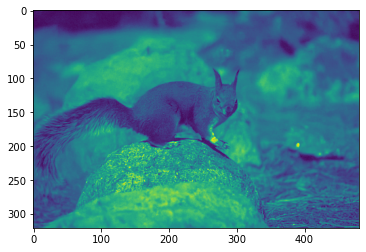

In [18]:
plt.imshow(x_)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('denoised10_nw.png', dpi=100)

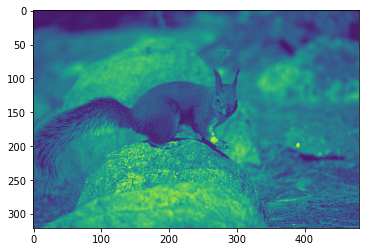

In [19]:
plt.imshow(grayscale)
# fig1 = plt.gcf()
# plt.show()
# plt.draw()
# fig1.savefig('original_nw.png', dpi=100)

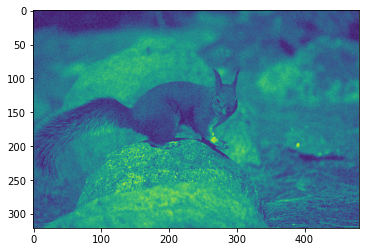

In [20]:
plt.imshow(y)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('noisy10_nw.png', dpi=100)
